<a href="https://colab.research.google.com/github/AayushGrover101/gan_chestxray/blob/master/GAN_ChestXray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np # linear algebra
import pandas as pd 

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os

from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from tqdm import tqdm

In [ ]:
# read files from google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
all_image_path = []

train_normal = glob.glob("/gdrive/My Drive/Colab Notebooks/data/train/NORMAL/*")
train_pneumonia = glob.glob("/gdrive/My Drive/Colab Notebooks/data/train/PNEUMONIA/*")

test_normal = glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/NORMAL/*")
test_pneumonia = glob.glob("/gdrive/My Drive/Colab Notebooks/data/test/PNEUMONIA/*")

In [ ]:
train_path = train_normal + train_pneumonia
test_path = test_normal + test_pneumonia

# resize to 64 by 64
train_path = [np.array((Image.open(path).convert("L").resize((64,64)))) for path in tqdm(train_path)]

100%|██████████| 5216/5216 [01:51<00:00, 46.70it/s]


In [ ]:
# normalize between 0 and 1
for i in tqdm(range(len(train_path))): 
    train_path[i] = ((train_path[i] - train_path[i].min())/(255 - train_path[i].min()))

100%|██████████| 5216/5216 [00:00<00:00, 15034.36it/s]


In [ ]:
len(train_path)

5216

In [ ]:
train_path = np.array(train_path)

In [ ]:
print(train_path.shape)

(5216, 64, 64)


  0%|          | 22/5216 [03:54<15:23:48, 10.67s/it]


<Figure size 720x720 with 0 Axes>

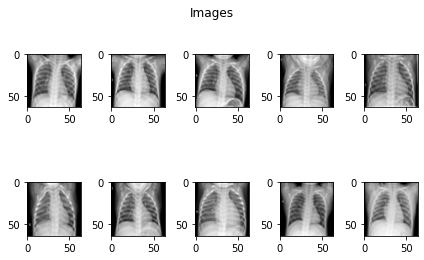

In [ ]:
# display images
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Images")
idx=8

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(train_path[idx].reshape(64,64), cmap="gray")            
            idx+=6
            
plt.tight_layout()
plt.show()

In [ ]:
noise_shape = 100

def generator_model():
  generator=Sequential()
  
  generator.add(Dense(4*4*512, input_shape=[noise_shape]))
  
  generator.add(Reshape([4,4,512]))
  generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(1, kernel_size=4, strides=2, padding="same",
                                  activation='sigmoid'))
  return generator

generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        2097408   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      5

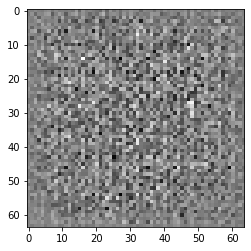

In [ ]:
# create random noise 
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

In [ ]:
def discriminator_model():
  discriminator = Sequential()
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64, 1]))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.4))
  discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))  
  discriminator.add(Dropout(0.4))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  return discriminator

discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                      

In [ ]:
GAN = Sequential([generator,discriminator])

discriminator.compile(optimizer='adam',loss='binary_crossentropy')

discriminator.trainable = False

GAN.compile(optimizer='adam',loss='binary_crossentropy')

GAN.layers

GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 1)         3583169   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 54209     
                                                                 
Total params: 3,637,378
Trainable params: 3,582,273
Non-trainable params: 55,105
_________________________________________________________________


In [ ]:
# training our gan

epochs = 15
batch_size = 64

loss_from_discriminator_model=[] 

loss_from_generator_model=[] 

with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently training on Epoch {epoch+1}")
    
    for i in range(train_path.shape[0]//batch_size):

        if (i)%100 == 0:
            print(f"\tCurrently training on batch number {i} of {len(train_path)//batch_size}")
        
        noise=np.random.uniform(-1,1,size=[batch_size, noise_shape])
    
        gen_image = generator.predict_on_batch(noise)
        train_dataset = train_path[i*batch_size:(i+1)*batch_size]
        
        train_labels_real=np.ones(shape=(batch_size,1))
        
        discriminator.trainable = True
        
        d_loss_real = discriminator.train_on_batch(train_dataset,train_labels_real)
        
        train_labels_fake=np.zeros(shape=(batch_size,1))
        
        d_loss_fake = discriminator.train_on_batch(gen_image,train_labels_fake)
        
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        train_label_fake_for_gen_training =np.ones(shape=(batch_size,1))
        
        discriminator.trainable = False
        
        g_loss = GAN.train_on_batch(noise, train_label_fake_for_gen_training)
        
        loss_from_discriminator_model.append(d_loss_real+d_loss_fake)
        
        loss_from_generator_model.append(g_loss)
        
        # show images
        if epoch % 3 == 0:
            samples = 10
            x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(64,64), cmap="gray")
                plt.xticks([])
                plt.yticks([])

            
            plt.tight_layout()
            plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss_real, d_loss_fake, g_loss))        

print('Training completed with all epochs')

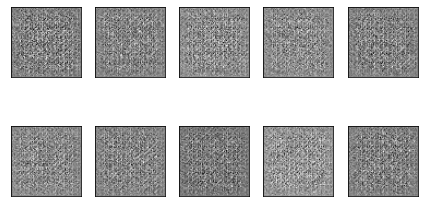

In [ ]:
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(64,64), cmap="gray")
    plt.xticks([])
    plt.yticks([])


plt.tight_layout()
plt.show()

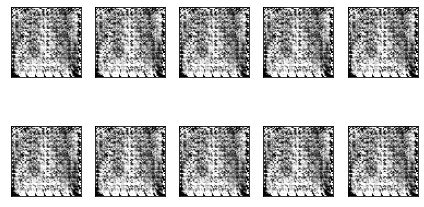

In [ ]:
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(64,64), cmap="gray")
    plt.xticks([])
    plt.yticks([])


plt.tight_layout()
plt.show()

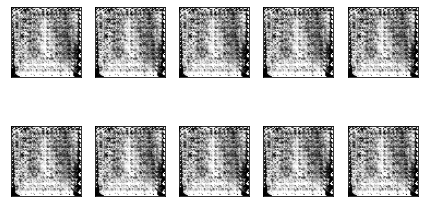

In [ ]:
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(64,64), cmap="gray")
    plt.xticks([])
    plt.yticks([])


plt.tight_layout()
plt.show()

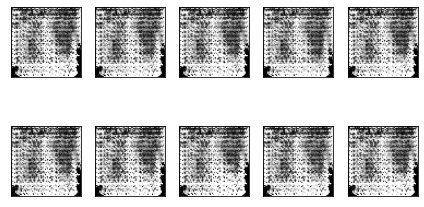

In [ ]:
samples = 10
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(64,64), cmap="gray")
    plt.xticks([])
    plt.yticks([])


plt.tight_layout()
plt.show()